# <font style="color:rgb(50,120,229)">Automated PDF Redaction </font>

### <font style = "color:rgb(8,133,37)">Project Goal</font>

Use machine learning algorithms combined with Natural Language Processing techniques to intelligently identify and remove sensitive information from the documents. Reduce human error and processing time which results from manual indentification of sensitive information in the documents such as social security numbers, addresses and dates of birth. Custom based rules will insure compliance with high standards of information security. 

### <font style = "color:rgb(8,133,37)">Project Challenges</font>


#### <font style = "color:rgb(0,0,0)">PDF structure</font>
 * PDF files are either 8-bit binary files or 7-bit ASCII text files (using ASCII-85 encoding).
 * Every line in a PDF can contain up to 255 characters.
 * Every line ends with a carriage return, a line feed or a carriage return followed by a line feed (depending upon the application or platform used to create the PDF file).
 * PDF is case sensitive.
 * The file format is completely independent from the platform that it is viewed or created on. Files can be moved back and forth between Macs, Windows system, Linux systems,… When FTP-ing a PDF file, it does make sense to compress it, to avoid data corruption by some outdated web system that the file needs to go through.
 * Scanned PDFs are stored as images 

#### <font style = "color:rgb(0,0,0)">Structured PDF redacting</font>

Structured PDF consists of four main parts: Header, Body, Cross-reference table and Trailer. These parts contain multiple objects: page objects, image objects, font objects,  bookmark objects, forms objects, etc. Since all objects are unique, pattern recognition (RegEx) can be used to parse and redact the document. A sample code for the structured PDF is below.The code is written by Dr.Joshua Tauberer and its full version can be viewed [on his Github repository](https://github.com/JoshData/pdf-redactor)

```Python
# A general-purpose PDF text-layer redaction tool.

import sys
from datetime import datetime

if sys.version_info >= (3,):
# pdfrw is broken in Py 3 for xref tables. This monkeypatching fixes it
# by making binascii.hexlify work with a (unicode) string passed to it.
# Assume the string is Latin-1 encoded since that's what pdfrw assumes
# throughout.
import binascii
original_hexlify = binascii.hexlify
binascii.hexlify = lambda x : original_hexlify(x if isinstance(x, bytes) else x.encode("latin-1"))

class RedactorOptions:
"""Redaction and I/O options."""

# Input/Output
    if sys.version_info < (3,):
        input_stream = sys.stdin # input stream containing the PDF to redact
        output_stream = sys.stdout # output stream to write the new, redacted PDF to
    else:
        input_stream = sys.stdin.buffer # input byte stream containing the PDF to redact
        output_stream = sys.stdout.buffer # output byte stream to write the new, redacted PDF to

    # Metadata filters map names of entries in the PDF Document Information Dictionary
    # (e.g. "Title", "Author", "Subject", "Keywords", "Creator", "Producer", "CreationDate",
    # and "ModDate") to an array of functions to run on the values of those keys.
    #
    # Each function is given a pdfrw.objects.PdfString containing the current field value,
    # or None if the field is not present in the input PDF, as the function's first argument
    # and it must return either a string, a datetime.datetime value (CreationDate and ModDate
    # should datetime.datetime values), or None to replace the field's value with. Return
    # None to clear the field (unless a later function adds a new value).
    #
    # The functions are run in order. Each function is given the previous function's return
    # value. The last function's return value is put into the output PDF.
    #
    # If a datetime.datetime is returned without timezone info (a "naive" datetime), then
    # it must be in UTC. Use pytz.timezone.localize to encode a local time.
    #
    # Use "DEFAULT" as a key to apply functions to all metadata fields that have no specific
    # functions defined, which is useful to remove all unrecognized fields.
    #
    # Use "ALL" to appy functions to all metadata fields, after any field-specific
    # functions or DEFAULt functions are run.
    metadata_filters = { }

    # The XMP metadata filters are functions that are passed any existing XMP data and
    # return new XMP metadata. The functions are called in order and each is passed the
    # result of the previous function. The functions are given an xml.etree.Element object,
    # or None, as their first argument and must return an object of the same type, or None.
    xmp_filters = []

    # This function controls how XML returned by xmp_filters is serialized. Replace this
    # function with any function that takes an xml.etree.Element object and returns a string
    # (a unicode string --- don't serialize to bytes).
    xmp_serializer = None

    # The content filters are run on the combined content streams of the pages.
    #
    # Each filter is a tuple of a compiled regular expression and a function to generate
    # replacement text, which is given a re.Match object as its sole argument. It must return a string.
    #
    # Since spaces in PDFs are sometimes not encoded as text but instead as positional
    # offsets (like newlines), the regular expression should treat all spaces as optional.
    #
    # Since pdfrw doesn't support content stream compression, you should use a tool like qpdf
    # to decompress the streams before using this tool (see the README).
    content_filters = []

    # When replacement text isn't likely to have a glyph stored in the PDF's fonts,
    # replace the character with these other characters (if they don't have the same
    # problem):
    content_replacement_glyphs = ['?', '#', '*', ' ']


def redactor(options):
    # This is the function that performs redaction.

    from pdfrw import PdfReader, PdfWriter

    # Read the PDF.
    document = PdfReader(options.input_stream)

    # Modify its Document Information Dictionary metadata.
    update_metadata(document, options)

    # Modify its XMP metadata.
    update_xmp_metadata(document, options)

    if options.content_filters:
        # Build up the complete text stream of the PDF content.
        text_layer = build_text_layer(document, options)

        # Apply filters to the text stream.
        update_text_layer(options, *text_layer)

        # Replace page content streams with updated tokens.
        apply_updated_text(document, *text_layer)

    # Write the PDF back out.
    writer = PdfWriter()
    writer.trailer = document
    writer.write(options.output_stream)
```

#### <font style = "color:rgb(0,0,0)">Scanned PDF redacting</font>

Scanned PDF is saved as an image and has no underlying structure. Optical Character Recognition (OCR) is used to extract text information from the image. Natural Language Processing (NLP) then is used to identify and redact the information. Sample code using OCR and NLP is below. The full code is on my [Github repository](https://github.com/Anyulund/NLP-materials/tree/master/Resume_parsing)

```Python
for num in range(0, 1): # the range is the number of the files in the folder
  file_name = f"result{num}.txt"
  file = open(file_name)
  doc = nlp(file.read())
  print(doc)
  file.close()
  for ent in doc.ents:
      print (ent.text, ent.label_)
for ent in doc.ents:
  if ent.label_ == 'DATE':
      date.append(ent)
  elif ent.label_ == 'ORG':
      organization.append(ent)
  elif ent.label_ == 'PERSON':
      names.append(ent)
  elif ent.label_ == 'GPE':
      location.append(ent)
  elif ent.label_ == 'CARDINAL':
      phone.append(ent)
      break
print('Name:',names)
print('Organizaton:',organization)
print ('Location:', location)
print ('Phone or email:', phone)
```

#### <font style = "color:rgb(0,0,0)">Natural Language Processing Considerations</font>

After NLP is used to identify and sort sensored text data from images, there are three routes that can be implemented depending on time and resources availability. 

* Route 1: Write redacted information from text to a new PDF file. All layout will be lost. The formatting can be kept after applying effort to restore it.  
* Route 2: Use OCR to identify where in the document indentified sensitive information is located, draw a box around it, and replace the pixels with information in the box with the black pixels. 
* Route 3: Do not use NLP, and just train the Machine Learning Model on image recognition to recognize the information using Computer Vision. 

Further research is needed to identify pros, cons and costs of each method. Few highlighted topics that should be considered when deciding on whether NLP project is feasible are listed below - courtesy of Search Technologies. Their full blog on Natural Language Processing is [here](https://www.searchtechnologies.com/blog/natural-language-processing-techniques)


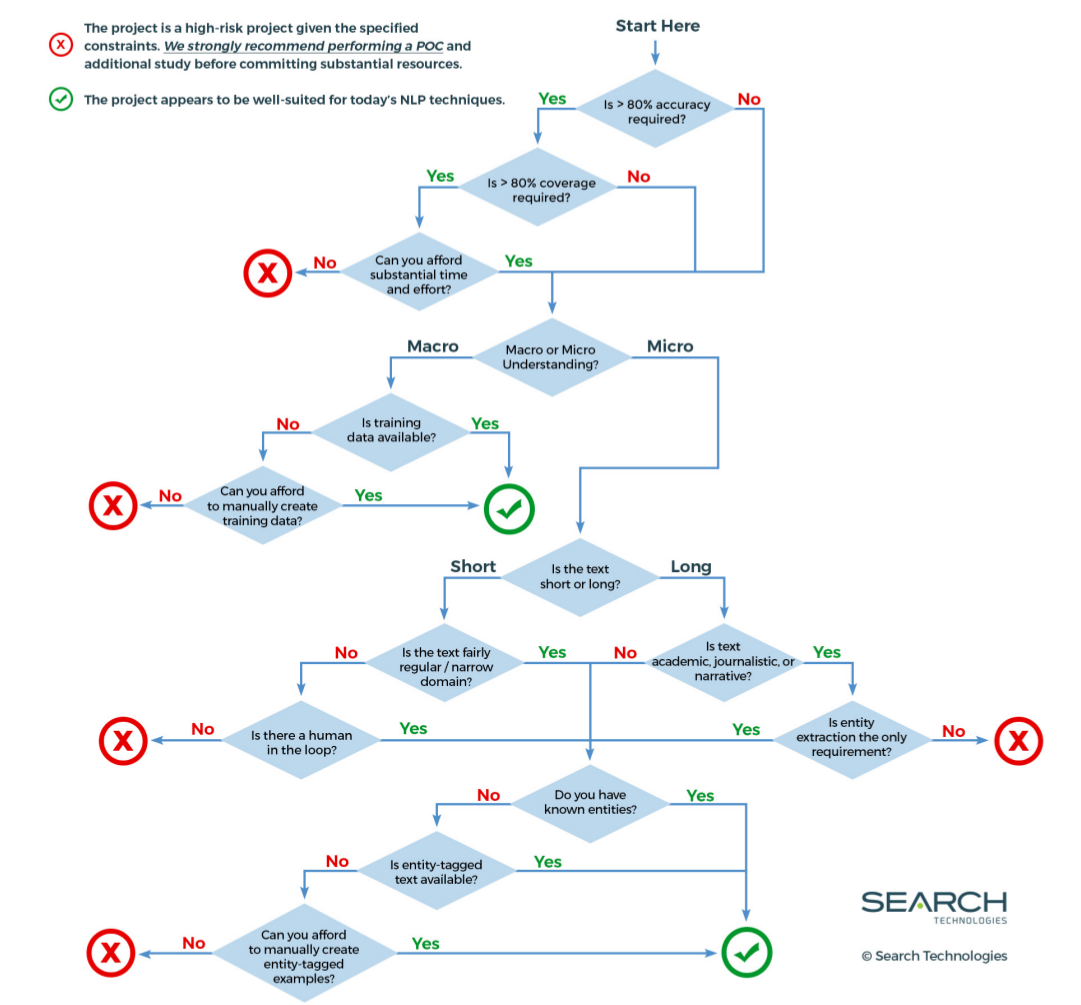

##### <font style = "color:rgb(0,0,0)">Is > 80% accuracy required? </font>
* Accuracy in this context is the percentage of records where the correct answer is produced. 
* High accuracy systems generally require much more work to handle many more text variations, and the work gets harder and harder, especially above 80%. 
* Lower accuracy systems are often still useful for large-scale analytics and trend analysis. 

##### <font style = "color:rgb(0,0,0)">Is > 80% coverage required? </font>
* Coverage in this context is the percent of applicable records for which an answer is provided. 
    - An "applicable record" is a record which contains text that provides the desired understanding. 
* High coverage systems generally require much more work to handle many more text variations, and the work gets harder and harder above 80% coverage. 

##### <font style = "color:rgb(0,0,0)">Is training data available? </font>
* Training data is typically required to train statistical models for many types of understanding. 
* Training data may already be available if: 
    - The system is replacing a process which was previously done manually
    - The system is filling gaps for manually entered values, for example, by end users filling out forms
    - Public training data is available
    - Log data from end-user interactions can sometimes be used to infer training data
    - Appropriate third party metadata is available for a portion of the content

##### <font style = "color:rgb(0,0,0)">Can you afford to manually create training data? </font>
* If training data is not available and cannot be inferred, then it will need to be created manually for msot types of macro understanding. 
* Depending on the scope of the project, this can be done by just a few people, or it could require a larger team perhaps even using a crowd-sourcing model. 

##### <font style = "color:rgb(0,0,0)">Is the text faily regular / narrow domain? </font> 
* This question often has more to do with the authors of the text than the text itself. 
* If the authors are similar across the board, then they will typically produce fairly regular text that spans a fairly narrow domain.
* On other hand, if the authors cover a wide range of backgrounds, education levels, and language skills, then typically they will produce a wide range of text variation across a wide domain. This will be difficult to process. 

##### <font style = "color:rgb(0,0,0)">Is there human in the loop? </font> 
* In some applications, there will be human review	of the	results. Such applicaons will generally	be more tolerant of	errors produced by	the	understanding algorithms.
* For example, a system may extract statements which indicate compliance violations. These would, of necessity, need to be	checked	by a compliance officer to	determine if a rule	wa 	actually violated.

##### <font style = "color:rgb(0,0,0)">Is entity extraction the only requirement? </font> 
* In our case it seems that indeed entity extraction is the only NLP requirement here. 
* Known entities come form entity lists that have been previously gathered ahead of time. These can be things like social security numbers, names, addresses, etc. In this case, these entities should be collected according to Freedom of Information Act. 
* Consider entities are not previously known to the system. These can include people names, company names, locations, etc. Unknown entities can only be determined by looking at names in context. 

##### <font style = "color:rgb(0,0,0)">Is entity-tagged text available? </font> 
* Unknown entities will need to be determined based on context (e.g. the words around the entity). This can be done statistically if sufficient tagged examples exist. In our case, RegEx on structured PDFs can be used to label entities. This labeled data can be used later on image PDFs. 
* Sometimes (rarely) entity-tagged text can come from public sources. Other times it may come from tagging in the content (e.g. embedded HTML markup) or by wathing the user interact with cut and paste. 

##### <font style = "color:rgb(0,0,0)">Can you afford to manually create entity-tagged examples? </font> 
* If entity-tagged text is not available, then it may need to be manually created. This can be an expensive process, since, usually 500+ examples are required to achieve good accuracy. To achieve > 80% accuracy, as many as 2,000 to 5,000 examples may be required for good accuracy. 